# TabNN: Titanic Survival Prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tabnn_model import TabNNModel
from utils import random_masking, plot_feature_importances

In [2]:
# 1. Load Titanic data
df = pd.read_csv("titanic.csv")

# 2. Define feature & target columns
input_features = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Cabin", "Embarked"]
#target_features = ["Survived"]
target_features = ["Survived", "Pclass", "Sex", "SibSp"]


# 3. Split into train/test
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [3]:
train_df.shape

(712, 12)

In [4]:
test_df.shape

(179, 12)

In [5]:
train_df.head()

PassengerId  Survived  Pclass                                Name  \
331          332         0       1                 Partner, Mr. Austen   
733          734         0       2          Berriman, Mr. William John   
382          383         0       3                  Tikkanen, Mr. Juho   
704          705         0       3             Hansen, Mr. Henrik Juul   
813          814         0       3  Andersson, Miss. Ebba Iris Alfrida   

        Sex   Age  SibSp  Parch             Ticket     Fare Cabin Embarked  
331    male  45.5      0      0             113043  28.5000  C124        S  
733    male  23.0      0      0              28425  13.0000   NaN        S  
382    male  32.0      0      0  STON/O 2. 3101293   7.9250   NaN        S  
704    male  26.0      1      0             350025   7.8542   NaN        S  
813  female   6.0      4      2             347082  31.2750   NaN        S

In [6]:
# 4. Instantiate & train on the training set only
model = TabNNModel(
    input_feature_list=input_features,
    target_list=target_features,
    embedding_strategy="embedding",
    onehot_pca_components=8,
    hidden_layers=[128, 64],
    dropout=0.1,
    learning_rate=1e-5,
    batch_size=16,
    num_epochs=30,
    optimizer_type="adam",
    mask_value=-1,
    mask_prob=0.5,
    mask_seed=42,
    upsampling_factor=5,
    validation_split=0.1,
    random_state=42
)

model.fit(train_df)

In [7]:
importances_raw = model.feature_importance_scores(train_df)
importances_raw

{'Pclass': 0.00013856696023140103,
 'Age': 0.0008615213446319103,
 'SibSp': 1.5896781405899674e-05,
 'Parch': 7.416988864861196e-06,
 'Fare': 0.00045900006080046296,
 'Sex': 0.00010378228034824133,
 'Cabin': 2.4418488465016708e-05,
 'Embarked': 5.268042968964437e-06}

In [8]:
importances_normalized = model.feature_importance_scores(train_df, normalize=True)
importances_normalized

{'Pclass': 0.15567696732211628,
 'Age': 1.0,
 'SibSp': 0.012413077317533213,
 'Parch': 0.0025097081572979046,
 'Fare': 0.529903962939818,
 'Sex': 0.11505268030844437,
 'Cabin': 0.022365397551004855,
 'Embarked': 0.0}

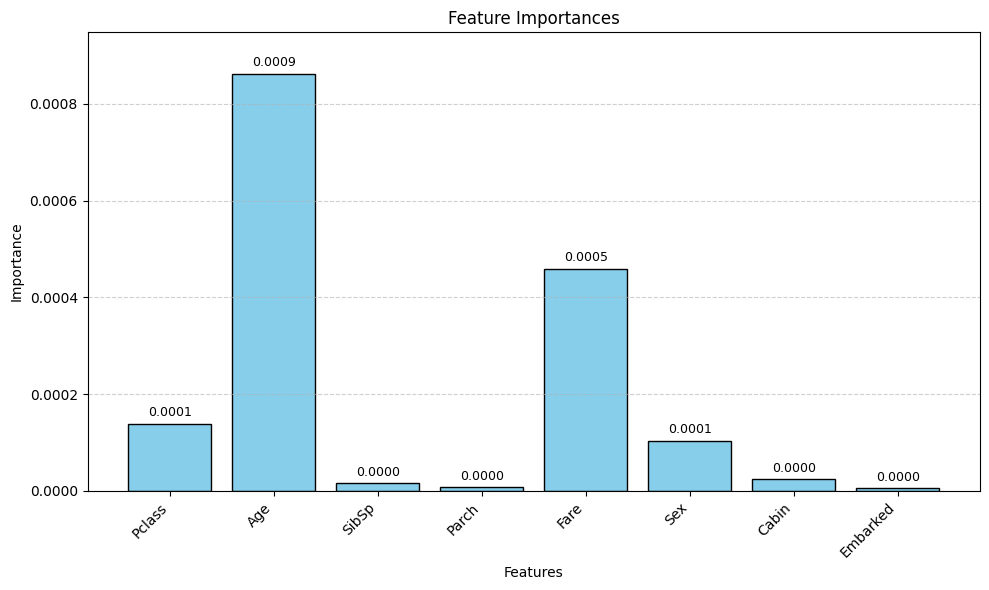

In [9]:
plot_feature_importances(importances_raw, title="Feature Importances")

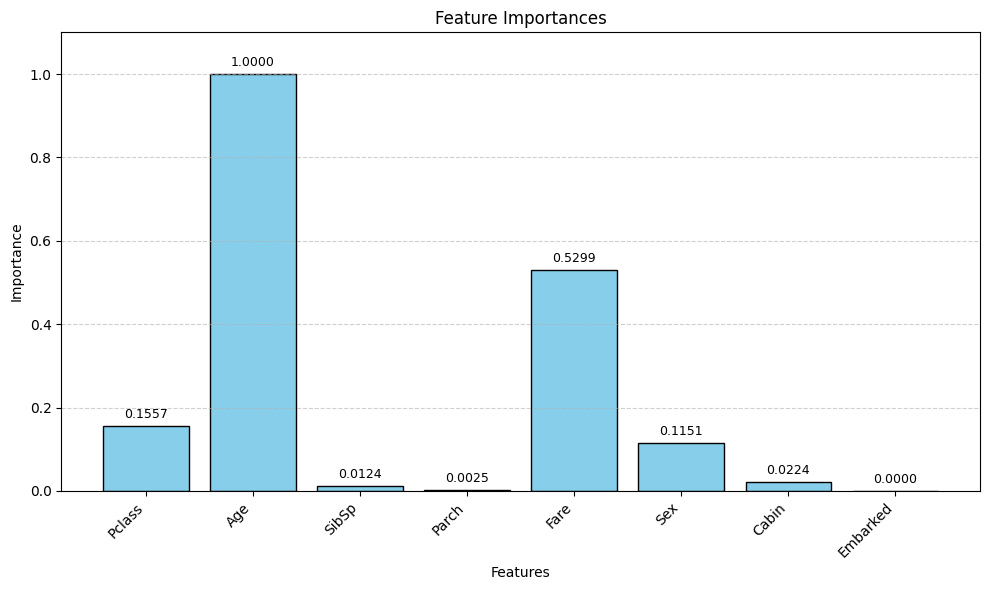

In [10]:
plot_feature_importances(importances_normalized, title="Feature Importances")

In [11]:
len(model.history['train_loss'])

60

In [12]:
len(model.history['val_loss'])

30

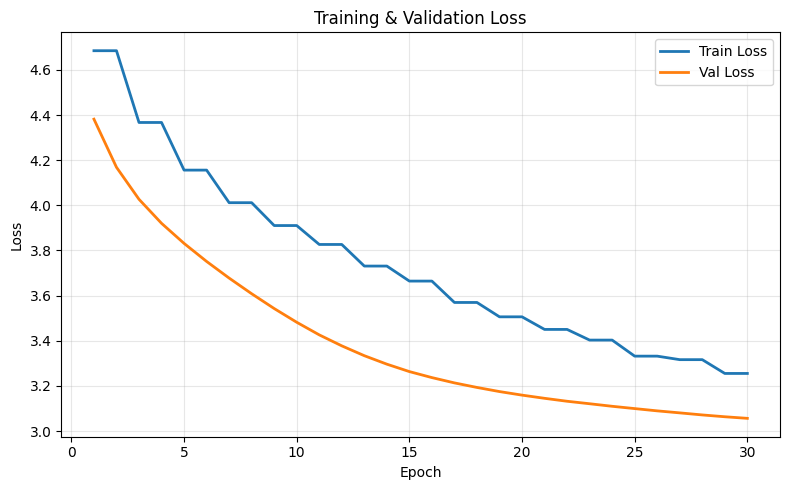

In [13]:
model.plot_training_history()

In [14]:
# 5. Evaluate on the test set
# Mask test set
np.random.seed(1)
test_df_masked = test_df.map(lambda x: random_masking(value=x, mask_prob=0.5))
proba_dict = model.predict_proba(test_df_masked)
preds = {
    tgt: np.argmax(probas, axis=1)
    for tgt, probas in proba_dict.items()
}

In [15]:
test_df

PassengerId  Survived  Pclass  \
709          710         1       3   
439          440         0       2   
840          841         0       3   
720          721         1       2   
39            40         1       3   
..           ...       ...     ...   
433          434         0       3   
773          774         0       3   
25            26         1       3   
84            85         1       2   
10            11         1       3   

                                                  Name     Sex   Age  SibSp  \
709  Moubarek, Master. Halim Gonios ("William George")    male   NaN      1   
439             Kvillner, Mr. Johan Henrik Johannesson    male  31.0      0   
840                        Alhomaki, Mr. Ilmari Rudolf    male  20.0      0   
720                  Harper, Miss. Annie Jessie "Nina"  female   6.0      0   
39                         Nicola-Yarred, Miss. Jamila  female  14.0      1   
..                                                 ...     ...   ...    ...   
433                         Kallio, Mr. Nikolai Erland    male  17.0      0   
773                                    Elias, Mr. Dibo    male   NaN      0   
25   Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...  female  38.0      1   
84                                 Ilett, Miss. Bertha  female  17.0      0   
10                     Sandstrom, Miss. Marguerite Rut  female   4.0      1   

     Parch             Ticket     Fare Cabin Embarked  
709      1               2661  15.2458   NaN        C  
439      0         C.A. 18723  10.5000   NaN        S  
840      0   SOTON/O2 3101287   7.9250   NaN        S  
720      1             248727  33.0000   NaN        S  
39       0               2651  11.2417   NaN        C  
..     ...                ...      ...   ...      ...  
433      0  STON/O 2. 3101274   7.1250   NaN        S  
773      0               2674   7.2250   NaN        C  
25       5             347077  31.3875   NaN        S  
84       0         SO/C 14885  10.5000   NaN        S  
10       1            PP 9549  16.7000    G6        S  

[179 rows x 12 columns]

In [16]:
preds

{'Survived': array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1]),
 'Pclass': array([2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0,
        2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [17]:
print("Test Set Metrics:")
for tgt in target_features:
    encoder_map = model.target_label_encoders[tgt]
    y_true = test_df[tgt].map(encoder_map).astype(int).values
    y_pred = preds[tgt]

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1   = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"{tgt:8s}  acc={acc:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1={f1:.3f}")

Test Set Metrics:
Survived  acc=0.642  prec=0.703  rec=0.642  f1=0.566
Pclass    acc=0.609  prec=0.564  rec=0.609  f1=0.518
Sex       acc=0.631  prec=0.633  rec=0.631  f1=0.536
SibSp     acc=0.687  prec=0.568  rec=0.687  f1=0.584
